<center><h1> Introduction </h1></center>


* **Competition** - Given a set of images of Cassava leaves we need to classify them as one of the four diseases or healthy.
* **Data** - A collection of 21397 labelled images
* **Evaluation** - Classification accuracy

We will take a quick look at the data files and train our model in this notebook. The model can be saved and used for inference in a later notebook.

<center><h1> Importing necessary libraries </h1></center> 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
ROOT_DIR = '../input/cassava-leaf-disease-classification/'
os.listdir(ROOT_DIR)

import json # to read in the 'label_num_to_disease_map.json' file

In [2]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import cv2
import random

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.utils import plot_model

In [5]:
# set the training and test directory paths
TRAIN_DIR = '../input/cassava-leaf-disease-classification/train_images/'
TEST_DIR = '../input/cassava-leaf-disease-classification/test_images/'

In [6]:
# set seed
seed = 42

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed)

<center><h1> Data exploration </h1></center> 

In [7]:
train_df = pd.read_csv(ROOT_DIR + 'train.csv')
sample_df = pd.read_csv(ROOT_DIR + 'sample_submission.csv')

In [8]:
print(train_df.shape, sample_df.shape)
display(train_df.head())

(21397, 2) (1, 2)


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [9]:
f = open(ROOT_DIR + 'label_num_to_disease_map.json')
data = json.load(f)
print(json.dumps(data, indent = 2))

{
  "0": "Cassava Bacterial Blight (CBB)",
  "1": "Cassava Brown Streak Disease (CBSD)",
  "2": "Cassava Green Mottle (CGM)",
  "3": "Cassava Mosaic Disease (CMD)",
  "4": "Healthy"
}


In [10]:
z = train_df.sample(20)
display(z)
images, labels = z['image_id'].tolist(), z['label'].tolist()

,image_id,label
9134,2615227158.jpg,4
1580,1277648239.jpg,3
7304,2305895487.jpg,3
13196,336299725.jpg,2
5333,1951270318.jpg,2
1453,1254294690.jpg,3
1527,1269832262.jpg,3
2767,1481899695.jpg,3
7895,240469234.jpg,3
19003,546602360.jpg,3


<center><h1> Plotting 20 randomly sampled images with class </h1></center> 

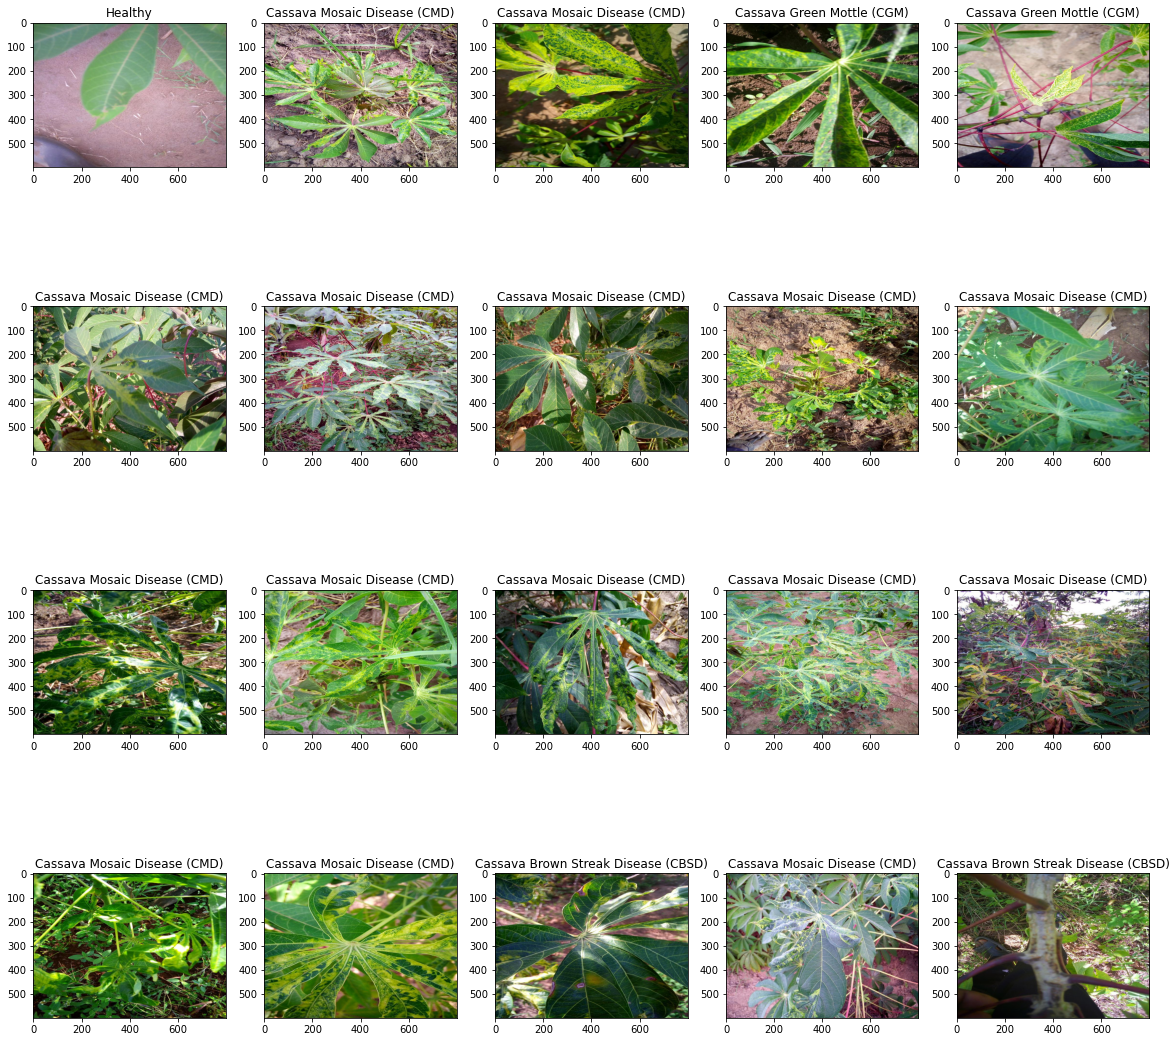

In [11]:
plt.figure(figsize = (20,20))
for i in range(20):
    plt.subplot(4,5,i+1)
    img = cv2.imread(TRAIN_DIR + images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(data[str(labels[i])])

<center><h1> Plotting a count plot and pie chart for class distribution. </h1></center> 

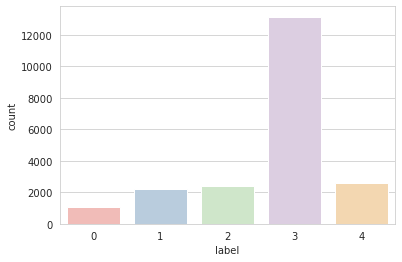

In [12]:
sns.set_style('whitegrid')
sns.countplot(x = 'label', data = train_df, palette = 'Pastel1');

In [13]:
pie_df = train_df['label'].value_counts().reset_index()
pie_df.columns = ['label', 'count']
fig = px.pie(pie_df, values = 'count', names = 'label', color_discrete_sequence = px.colors.qualitative.Pastel)
fig.show()

There is a class imbalance problem here. The Cassava Mosaic Disease (CMD) samples are more compared to other classes. We can solve this by either upsampling other class samples or downsampling the CMD samples.

<center><h1> Split dataset for training and validation </h1></center> 
<center> Reserving 15% of data for validation </center>

In [14]:
train_df = train_df.astype({"label": str})

In [15]:
train, test = train_test_split(train_df, test_size = 0.15, random_state = seed)
print(train.shape, test.shape)

(18187, 2) (3210, 2)


<center><h1> Creating ImageDataGenerator to generate data in batches and perform image augmentation. </h1></center> 

In [16]:
IMG_SIZE = 240
size = (IMG_SIZE,IMG_SIZE)

In [17]:
datagen = ImageDataGenerator(
                    rotation_range = 30,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    brightness_range = [0.5,1.5],
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest'
)

In [18]:
validgen = ImageDataGenerator()

In [19]:
train_generator = datagen.flow_from_dataframe(
                    train,
                    directory = TRAIN_DIR,
                    x_col = "image_id",
                    y_col = "label",
                    target_size = size,
                    class_mode = "sparse",
                    batch_size = 32,
                    shuffle = True,
                    seed = seed,
                    interpolation = "nearest"
)

Found 18187 validated image filenames belonging to 5 classes.


In [20]:
valid_generator = validgen.flow_from_dataframe(
                    test,
                    directory = TRAIN_DIR,
                    x_col = "image_id",
                    y_col = "label",
                    target_size = size,
                    class_mode = "sparse",
                    batch_size = 32,
                    shuffle = False,
                    seed = seed,
                    interpolation = "nearest"
)

Found 3210 validated image filenames belonging to 5 classes.


<center><h2> Visualizing some of the augmented images </h2></center>

### Image before Augmentation

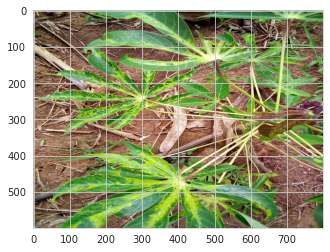

In [21]:
img = cv2.imread(os.path.join(TRAIN_DIR,'1000201771.jpg'))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Images after Augmentation

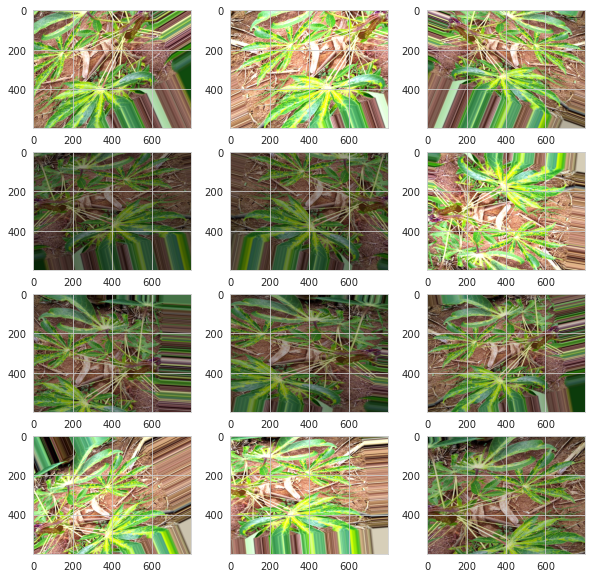

In [22]:
plt.figure(figsize = (10,10))
# set the title
plt.title('Augmented Images')
# load the image
img = load_img(os.path.join(TRAIN_DIR,'1000201771.jpg'))
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = np.expand_dims(data, 0)
# iterator
itr = datagen.flow(samples, batch_size = 1)
# generate samples and plot
for i in range(12):
    # define subplot
    plt.subplot(4,3,i+1)
    # generate batch of images
    batch = itr.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

<center><h1> Model creation and training </h1></center> 

In [23]:
NUM_CLASSES = 5

In [24]:
def create_model():
    
    model = models.Sequential()
    # initialize EfficientNetB model with input shape as (240,240,3)
    model.add(EfficientNetB1(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet'))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation = 'softmax'))
    
    return model

In [25]:
model = create_model()

27025408/27018416 [==============================] - 0s 0us/step


In [26]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(learning_rate = 0.001),
             metrics = ['accuracy'])

In [27]:
# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
#early_stopping = EarlyStopping(monitor = 'val_loss',
                              # patience = 5,
                               #mode = 'min',
                               #restore_best_weights = True)

# Save the model with the minimum validation loss
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = 'val_loss',
                             verbose = 1,
                             mode = 'min', 
                             save_best_only = True)
# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              min_lr = 0.001,
                              mode = 'min',
                              verbose = 1)

In [28]:

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

In [29]:
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = 5,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [checkpoint, reduce_lr]
                   )

Epoch 1/5
568/568 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.7351
Epoch 00001: val_loss improved from inf to 0.69721, saving model to best_model.hdf5
568/568 [==============================] - 591s 1s/step - loss: 0.7393 - accuracy: 0.7351 - val_loss: 0.6972 - val_accuracy: 0.7431
Epoch 2/5
568/568 [==============================] - ETA: 0s - loss: 0.5875 - accuracy: 0.7994
Epoch 00002: val_loss improved from 0.69721 to 0.49372, saving model to best_model.hdf5
568/568 [==============================] - 524s 922ms/step - loss: 0.5875 - accuracy: 0.7994 - val_loss: 0.4937 - val_accuracy: 0.8353
Epoch 3/5
568/568 [==============================] - ETA: 0s - loss: 0.5367 - accuracy: 0.8135
Epoch 00003: val_loss did not improve from 0.49372
568/568 [==============================] - 546s 962ms/step - loss: 0.5367 - accuracy: 0.8135 - val_loss: 0.5193 - val_accuracy: 0.8200
Epoch 4/5
568/568 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 6,904,460
Trainable params: 6,842,405
Non-trainable params: 62,055
_________________________________________________________________


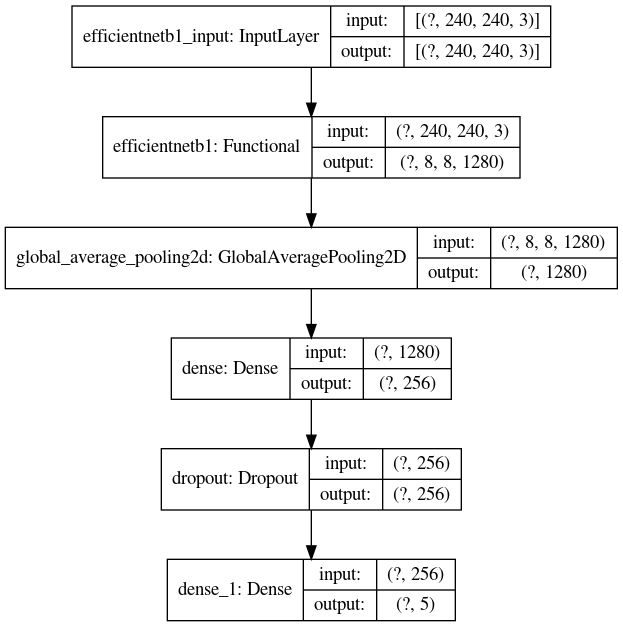

In [31]:
plot_model(model, show_shapes = True)

<center><h1> Model evaluation </h1></center> 

In [32]:
model.evaluate_generator(generator = valid_generator, steps = STEP_SIZE_VALID)

[0.6130397915840149, 0.7884374856948853]

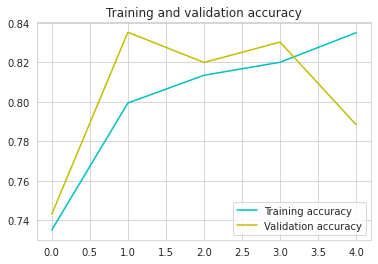

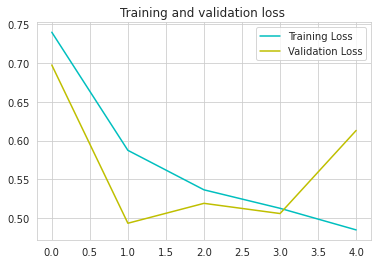

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'c-', label='Training accuracy')
plt.plot(epochs, val_acc, 'y-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'c-', label='Training Loss')
plt.plot(epochs, val_loss, 'y-', label='Validation Loss')
plt.title('Training and validation loss ')
plt.legend()

plt.show()

In [34]:
val1=max(acc)
print(val1)

0.8350867629051208


In [35]:
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = 20,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [checkpoint, reduce_lr]
                   )

Epoch 1/20
568/568 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.8363
Epoch 00001: val_loss did not improve from 0.49372
568/568 [==============================] - 554s 976ms/step - loss: 0.4777 - accuracy: 0.8363 - val_loss: 0.7516 - val_accuracy: 0.7131
Epoch 2/20
568/568 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8391
Epoch 00002: val_loss improved from 0.49372 to 0.45780, saving model to best_model.hdf5
568/568 [==============================] - 553s 973ms/step - loss: 0.4656 - accuracy: 0.8391 - val_loss: 0.4578 - val_accuracy: 0.8447
Epoch 3/20
568/568 [==============================] - ETA: 0s - loss: 0.4605 - accuracy: 0.8452
Epoch 00003: val_loss did not improve from 0.45780
568/568 [==============================] - 567s 997ms/step - loss: 0.4605 - accuracy: 0.8452 - val_loss: 0.5115 - val_accuracy: 0.8331
Epoch 4/20
568/568 [==============================] - ETA: 0s - loss: 0.4499 - accuracy: 0.8432
Epoch 00004: val_loss

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 8, 8, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 6,904,460
Trainable params: 6,842,405
Non-trainable params: 62,055
_________________________________________________________________


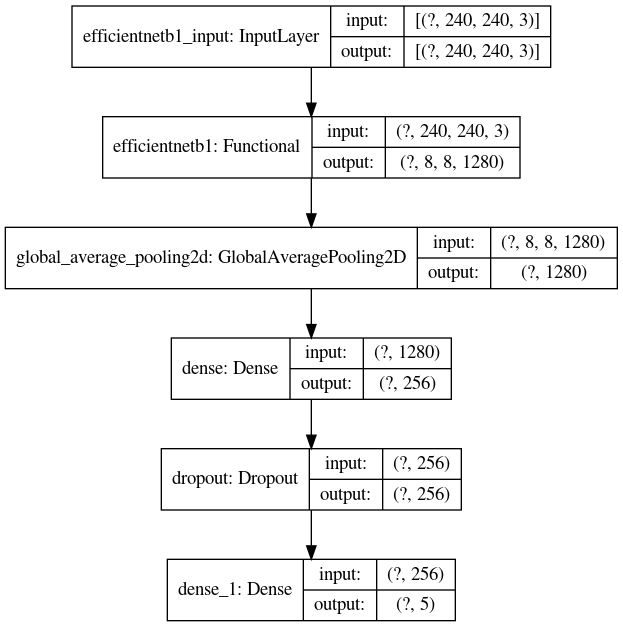

In [37]:
plot_model(model, show_shapes = True)

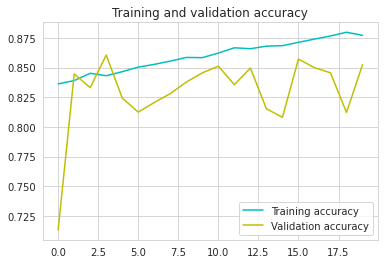

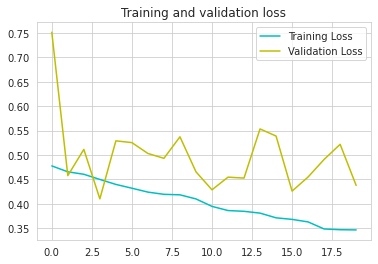

In [38]:
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

epochs1 = range(len(acc1))

plt.plot(epochs1, acc1, 'c-', label='Training accuracy')
plt.plot(epochs1, val_acc1, 'y-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs1, loss1, 'c-', label='Training Loss')
plt.plot(epochs1, val_loss1, 'y-', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
val2=max(acc1)
print(val2)

0.8798677921295166
